/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_70324/1677850210.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), horizontalalignment='center')
/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_70324/1677850210.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), horizontalalignment='center')
/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_70324/1677850210.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), horizontalalignment='center')


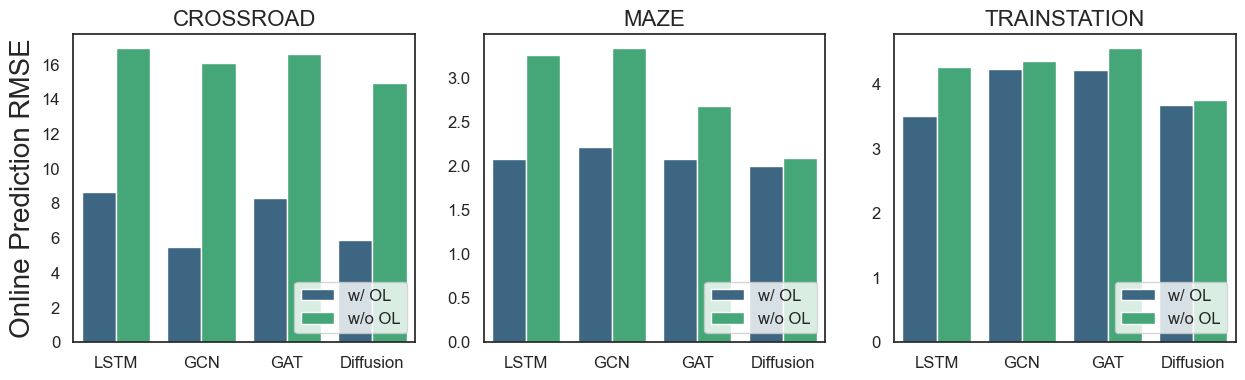

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = {
    "Models": ["LSTM", "LSTM w/o OL", "GCN", "GCN w/o OL", "GAT", "GAT w/o OL", "Diffusion", "Diffusion w/o OL"],
    "CROSSROAD": [8.63, 16.90, 5.44, 16.04, 8.31, 16.60, 5.86, 14.93],
    "MAZE": [2.08, 3.26, 2.21, 3.33, 2.07, 2.68, 2.00, 2.09],
    "TRAINSTATION": [3.50, 4.27, 4.23, 4.35, 4.21, 4.55, 3.68, 3.75]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting
df_melted = df.melt(id_vars="Models", var_name="Environment", value_name="Error")

# Add a new column to distinguish between OL and w/o OL
df_melted['OL'] = df_melted['Models'].apply(lambda x: 'w/ OL' if 'w/o OL' not in x else 'w/o OL')
df_melted['Model'] = df_melted['Models'].apply(lambda x: x.replace(' w/o OL', ''))

# Set the plot style
sns.set(style="white")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot for each environment
environments = ["CROSSROAD", "MAZE", "TRAINSTATION"]

for i, env in enumerate(environments):
    sns.barplot(
        ax=axes[i], 
        data=df_melted[df_melted['Environment'] == env], 
        x="Model", 
        y="Error", 
        hue="OL", 
        palette="viridis"
    )
    axes[i].set_title(f'{env}', fontsize=16)
    axes[i].set_xlabel(None, fontsize=14)
    if i == 0:
        axes[i].set_ylabel('Online Prediction RMSE', fontsize=20)
    else:
        axes[i].set_ylabel(None)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), horizontalalignment='center')
    # ticks
    axes[i].tick_params(axis='both', labelsize=12)
    # set location lower right
    axes[i].legend(title=None, fontsize=12, loc='lower right')

# Adjust layout
# plt.tight_layout()
# save the plot as pdf
# plt.savefig('./fig/online_learning_bar.pdf', bbox_inches='tight')
# Display the plot
plt.show()


In [72]:
# calculate percentage decrease
w_ol = [3.50, 4.23,  4.21,  3.68]
wo_ol = [   4.27, 4.35, 4.55, 3.75]
percentage_decrease = [(w - wo) / wo * 100 for w, wo in zip(w_ol, wo_ol)]
percentage_decrease

[-18.032786885245894,
 -2.758620689655155,
 -7.47252747252747,
 -1.8666666666666623]

In [3]:
from lib.utils import gen_data_dict, process_sensor_data
from lib.utils import seperate_up_down
from dgl.data.utils import load_graphs
import pickle
from test_then_train.Online_Update import test_then_train_env
import torch
import logging
df_dict = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
# Define path to parent directory containing subdirectories with CSV files

# online testing
# dataset_name = "crossroad"
dataset_name = "train_station"
# dataset_name = "maze"
parent_dir = 'sc_sensor'
if dataset_name == "maze":
    with open("./sc_sensor/maze/flow_data.pkl", "rb") as f:
        data_dict = pickle.load(f)
else:
    df_dict = process_sensor_data(parent_dir, df_dict)
    data_dict = gen_data_dict(df_dict)
    data_dict = seperate_up_down(data_dict)

#seperate upstream and downstream
# data_dict = seperate_up_down(data_dict)
g_data = load_graphs('./graphs/graphs.bin')
if dataset_name == "crossroad":
    g = g_data[0][0]
    test_sc = ['sc_sensor/crossroad1', 'sc_sensor/crossroad2', 'sc_sensor/crossroad4', 'sc_sensor/crossroad5',
               'sc_sensor/crossroad1', 'sc_sensor/crossroad10', 'sc_sensor/crossroad11', 'sc_sensor/crossroad8',
               'sc_sensor/crossroad2_2', 'sc_sensor/crossroad6', 'sc_sensor/crossroad7', 'sc_sensor/crossroad9',]
    inbound_node = [0, 3, 5, 6]
    outbound_node = [1, 2, 4, 7]
    node_of_interest = outbound_node

    
elif dataset_name == "train_station":
    g = g_data[0][1]
    test_sc = ['sc_sensor/train1', 'sc_sensor/train3', 'sc_sensor/train5', 'sc_sensor/train11',
               'sc_sensor/train2', 'sc_sensor/train6', 'sc_sensor/train4', 'sc_sensor/train12',
               'sc_sensor/train1_2', 'sc_sensor/train7', 'sc_sensor/train8', 'sc_sensor/train13',
               'sc_sensor/train9', 'sc_sensor/train10']
    inbound_node = [3, 7, 4, 8, 11, 14, 17, 18, 21, 0]
    outbound_node = [2, 6, 5, 9, 10, 15, 16, 19, 20, 1]
    node_of_interest = outbound_node + [22, 23, 12, 13]
    
elif dataset_name == "maze":
    g = g_data[0][2]
    test_sc = ['sc_sensor/maze14', 'sc_sensor/maze2', 'sc_sensor/maze3', 'sc_sensor/maze1', 'sc_sensor/maze8',
               'sc_sensor/maze17', 'sc_sensor/maze16', 'sc_sensor/maze15', 'sc_sensor/maze19', 'sc_sensor/maze12',
               'sc_sensor/maze8_2', 'sc_sensor/maze10_2', 'sc_sensor/maze18', 'sc_sensor/maze13', 'sc_sensor/maze20']
    inbound_node = [3, 0, 18, 20, 14, 13, 9, 7]
    outbound_node = [2, 1, 19, 21, 15, 12, 8, 6]
    node_of_interest = outbound_node + [4, 5, 22, 23, 16, 17, 11, 10]
    

chunk_size = 45
lags = 5
'''Has to >= 2'''
pred_horizon = 7 # 3, 5
# test_env = test_then_train_env(data_dict, test_sc, chunk_size, pred_horizon, lags=lags, g=g)
test_env = test_then_train_env(data_dict, test_sc, chunk_size, pred_horizon, lags=lags, g=g, logger=logger)
# test_env.device = device

In [75]:
g

Graph(num_nodes=24, num_edges=48,
      ndata_schemes={}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32)})

In [5]:
# load prediction with different chunk size
import numpy as np
preds = {}
compute_time_maze = {}
compute_time_trainstation = {}
compute_time_crossroad = {}
error_dict = {}
model_dict = {}

model_list = ["Online_Diffusion"]#"Online_MA", "Online_GCN", "Online_GAT", "Online_LSTM", "Online_GCNLSTM"]
# train_steps = 130

for cs in [15, 30, 45, 60, 75, 90]:
    for m in model_list:
        try:
            # error_dict[m] = np.load(f"checkpoint/{m}_{dataset_name}_curve_error_chunk{cs}_lags{lags}_hor{pred_horizon}.npy")
            # preds[cs] = np.load(f"checkpoint/{m}_{dataset_name}_prediction_chunk{cs}_lags{lags}_hor{pred_horizon}.npy").transpose(0, 2, 1, 3).reshape(-1, g.num_nodes(), 6)
            compute_time_maze[cs] = np.load(f"checkpoint/{m}_maze_compute_time_chunk{cs}_lags{lags}_hor{pred_horizon}.npy")
            compute_time_trainstation[cs] = np.load(f"checkpoint/{m}_train_station_compute_time_chunk{cs}_lags{lags}_hor{pred_horizon}.npy")
            compute_time_crossroad[cs] = np.load(f"checkpoint/{m}_crossroad_compute_time_chunk{cs}_lags{lags}_hor{pred_horizon}.npy")
            # < 0 -> 0
            # preds[cs][preds[cs] < 0] = 0
        except:
            print(f"model_{m}, file not found")
            continue

In [6]:
# load label
from lib.utils import sliding_win  # to get the online label
label_list = []
sigma_list = []
sc_shift_signal = []
labels = {}
# model = model_dict["diffusion_uq"]
for cs in [15, 30, 45, 60, 75]:
    label_list = []
    for sc in test_sc:
        data = data_dict[sc]
    
        observation, label = sliding_win(data, lags=test_env.lags, horizons=test_env.pred_horizon)
        # observation, label = torch.FloatTensor(observation).permute(2, 0, 1), torch.FloatTensor(label).permute(2, 0, 1)
        observation, label = np.transpose(observation, [2, 0, 1]), np.transpose(label, [2, 0, 1])
        for i in range(0, observation.shape[1] - cs, cs):
            # pred = model.predict(observation[:, i:i+chunk_size, :])
            label_list.append(label[:, i:i+cs, :])
        sc_shift_signal.append(len(label_list) * cs)
        
    # labels = torch.stack(label_list, dim=0)  # ground truth for all scenarios
    labels[cs] = np.stack(label_list, axis=0).transpose(0, 2, 1, 3).reshape(-1, g.num_nodes(), 6)
# labels2d = np.concatenate([np.concatenate(labels, axis=1), 
#                            label[:, i+test_env.chunk_size:, :]], axis=1)

In [7]:
preds[75].shape, labels[75].shape

KeyError: 75

### For compute time

In [8]:
# plot mean of compute time and std for each chunk size, line plot
import matplotlib.pyplot as plt
import numpy as np

mean_time_maze = []
std_time_maze = []
mean_time_trainstation = []
std_time_trainstation = []
mean_time_crossroad = []
std_time_crossroad = []


for cs in [15, 30, 45, 60, 75, 90]:
    mean_time_maze.append(compute_time_maze[cs].mean())
    std_time_maze.append(compute_time_maze[cs].std())
    mean_time_trainstation.append(compute_time_trainstation[cs].mean())
    std_time_trainstation.append(compute_time_trainstation[cs].std())
    mean_time_crossroad.append(compute_time_crossroad[cs].mean())
    std_time_crossroad.append(compute_time_crossroad[cs].std())
    

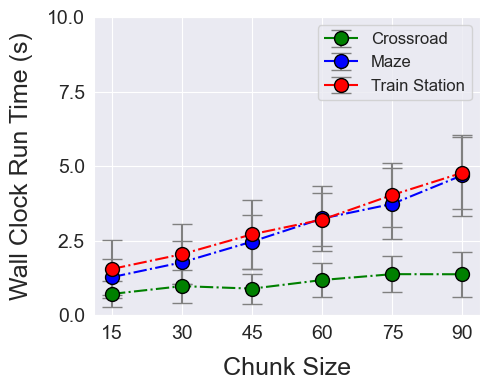

In [17]:
# Line plot with partial y-axis values and no grid
x_values = [15, 30, 45, 60, 75, 90]
plt.figure(figsize=(5, 4))  # Set the figure size for better readability

# Plot with improved error bars and marker style
plt.errorbar(x_values, mean_time_crossroad, yerr=std_time_crossroad, fmt='-.o',
                ecolor='gray', capsize=7, markersize=10,
                markerfacecolor='green', markeredgecolor='black',
                color='green', label='Crossroad')

plt.errorbar(x_values, mean_time_maze, yerr=std_time_maze, fmt='-.o', 
             ecolor='gray', capsize=7, markersize=10, 
             markerfacecolor='blue', markeredgecolor='black', 
             color='blue', label='Maze')

plt.errorbar(x_values, mean_time_trainstation, yerr=std_time_trainstation, fmt='-.o',
                ecolor='gray', capsize=7, markersize=10,
                markerfacecolor='red', markeredgecolor='black',
                color='red', label='Train Station')

# Customize the axes and title
plt.xlabel('Chunk Size', fontsize=18, labelpad=10)
plt.ylabel('Wall Clock Run Time (s)', fontsize=18, labelpad=10)

# Set y-axis limits for better scaling (optional)
plt.ylim(0, 10)

# Manually set y-ticks to show partial values
# yticks = np.linspace(min(mean_time) - max(std_time), max(mean_time) + max(std_time), 3)
yticks = np.linspace(0, 10, 5)
yticks = np.round(yticks, 2)
plt.yticks(yticks, fontsize=14)

# Add legend
plt.legend(fontsize=12)

# no grid
# plt.grid(False)
# white background
# plt.gca().set_facecolor('white')
# frame
# plt.gca().spines['top'].set_visible(False)

# Customize x-tick labels
plt.xticks(x_values, fontsize=14)

# Display the plot without grid
plt.tight_layout()
# plt.show()
# save the plot as pdf
# plt.savefig('./fig/compute_time.pdf', bbox_inches='tight')

### For sensitivity analysis figure 9

In [139]:
# error per chunk size
lstm_rmse_station = [3.587, 3.54, 3.532, 3.496, 3.486, 3.576, 3.53, 3.512, 3.653, 4.349]
lstm_mae_station = [2.373, 2.348, 2.347, 2.32, 2.322, 2.366, 2.34, 2.327, 2.409, 2.845]

diffusion_rmse_station = [3.709, 3.68, 3.674, 3.652, 3.65, 3.662, 3.622, 3.652, 3.641, 3.749]
diffusion_mae_station = [2.322, 2.314, 2.307, 2.297, 2.296, 2.301, 2.274, 2.295, 2.288, 2.35]

gcn_rmse_station = [4.279, 4.305, 4.254, 4.209, 4.211, 4.21, 4.24, 4.209, 4.265, 4.418]
gcn_mae_station = [2.876, 2.865, 2.847, 2.844, 2.883, 2.861, 2.859, 2.863, 2.889, 2.989]

gat_rmse_station = [4.436, 4.345, 4.246, 4.238, 4.187, 4.229, 4.228, 4.209, 4.239, 4.582]
gat_mae_station = [2.901, 2.861, 2.782, 2.793, 2.788, 2.791, 2.786, 2.777, 2.797, 2.903]

lstm_rmse_maze = [2.028, 2.077, 2.144, 2.222, 2.165, 2.231, 2.321, 2.413, 2.429, 3.261]
lstm_mae_maze = [1.448, 1.471, 1.517, 1.553, 1.535, 1.572, 1.639, 1.687, 1.734, 2.386]

diffusion_rmse_maze = [2.054, 2.002, 1.998, 1.995, 1.997, 1.986, 1.996, 1.997, 2.005, 2.089]
diffusion_mae_maze = [1.453, 1.409, 1.407, 1.403, 1.406, 1.398, 1.406, 1.403, 1.408, 1.477]

gcn_rmse_maze = [2.206, 2.208, 2.225, 2.242, 2.282, 2.31, 2.361, 2.394, 2.38, 3.329]
gcn_mae_maze = [1.604, 1.603, 1.618, 1.623, 1.649, 1.66, 1.692, 1.701, 1.696, 2.407]

gat_rmse_maze = [2.171, 2.065, 2.152, 2.146, 2.129, 2.183, 2.233, 2.197, 2.249, 2.685]
gat_mae_maze = [1.541, 1.47, 1.533, 1.528, 1.516, 1.548, 1.567, 1.559, 1.613, 1.98]





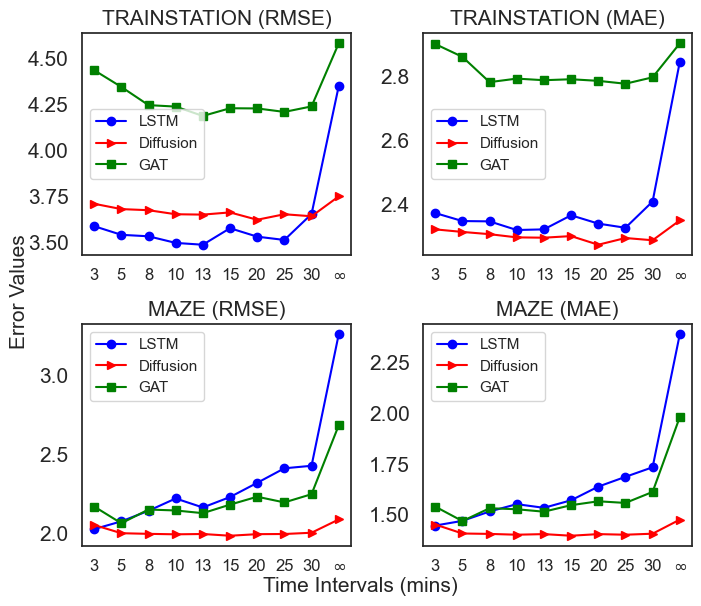

In [143]:
import matplotlib.pyplot as plt
import numpy as np

x_values = [15, 30, 45, 60, 75, 90, 120, 150, 180, 0]
x_ticks = [3, 5, 8, 10, 13, 15, 20, 25, 30, "$\infty$"]
x = np.arange(10)

# Create a figure with 2x2 subplots for RMSE and MAE comparisons
fig, axs = plt.subplots(2, 2, figsize=(7, 6))  # 2 rows, 2 columns

# Plot RMSE for the train station in the first subplot (0, 0)
axs[0, 0].plot(x, lstm_rmse_station, '-o', color='blue', label='LSTM')
axs[0, 0].plot(x, diffusion_rmse_station, '->', color='red', label='Diffusion')
axs[0, 0].plot(x, gat_rmse_station, '-s', color='green', label='GAT')
axs[0, 0].set_title('TRAINSTATION (RMSE)', fontsize=15)
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(x_ticks, fontsize=12)
axs[0, 0].tick_params(axis='y', labelsize=15)
axs[0, 0].legend()
# axs[0, 0].grid()

# Plot MAE for the train station in the second subplot (0, 1)
axs[0, 1].plot(x, lstm_mae_station, '-o', color='blue', label='LSTM')
axs[0, 1].plot(x, diffusion_mae_station, '->', color='red', label='Diffusion')
axs[0, 1].plot(x, gat_mae_station, '-s', color='green', label='GAT')
axs[0, 1].set_title('TRAINSTATION (MAE)', fontsize=15)
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(x_ticks, fontsize=12)
axs[0, 1].tick_params(axis='y', labelsize=15)
axs[0, 1].legend()
# axs[0, 1].grid()

# Plot RMSE for the maze in the third subplot (1, 0)
axs[1, 0].plot(x, lstm_rmse_maze, '-o', color='blue', label='LSTM')
axs[1, 0].plot(x, diffusion_rmse_maze, '->', color='red', label='Diffusion')
axs[1, 0].plot(x, gat_rmse_maze, '-s', color='green', label='GAT')
axs[1, 0].set_title('MAZE (RMSE)', fontsize=15)
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(x_ticks, fontsize=12)
axs[1, 0].tick_params(axis='y', labelsize=15)
axs[1, 0].legend()
# axs[1, 0].grid()

# Plot MAE for the maze in the fourth subplot (1, 1)
axs[1, 1].plot(x, lstm_mae_maze, '-o', color='blue', label='LSTM')
axs[1, 1].plot(x, diffusion_mae_maze, '->', color='red', label='Diffusion')
axs[1, 1].plot(x, gat_mae_maze, '-s', color='green', label='GAT')
axs[1, 1].set_title('MAZE (MAE)', fontsize=15)
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(x_ticks, fontsize=12)
axs[1, 1].tick_params(axis='y', labelsize=15)
axs[1, 1].legend()
# axs[1, 1].grid()

# Set the labels for the entire figure
fig.text(0.5, 0., 'Time Intervals (mins)', ha='center', fontsize=15)
fig.text(0., 0.5, 'Error Values', va='center', rotation='vertical', fontsize=15)

plt.tight_layout()
# plt.show()
# save the plot as pdf
# plt.savefig('./fig/sensitivity_analysis.pdf', bbox_inches='tight')